In [37]:
import pandas as pd
import networkx as nx  
import collections  
import matplotlib.pyplot as plt  
import numpy as np
import scipy.sparse.linalg as linalg

In [11]:
G = nx.read_edgelist('datasets/phonecalls.edgelist.txt')
print(G)

Graph with 36595 nodes and 56853 edges


### A. Tamanho da Rede
O NetworkX oferece funções diretas para obter o número de nós: G.number\_of\_nodes() ou, de forma mais concisa, len(G).

N nós.

In [12]:
num_nodes = G.number_of_nodes()  
print(f"Tamanho da Rede (Número de Nós): {num_nodes} nós")


Tamanho da Rede (Número de Nós): 36595 nós


### B. Número de Links (Arestas)

O NetworkX fornece a função G.number\_of\_edges() para obter o número total de arestas. Alternativamente, o método G.size() oferece um resultado idêntico.9 Para a rede em análise, assume-se que contém


M links.

In [13]:
num_edges = G.number_of_edges()  
print(f"Número de Links (Arestas): {num_edges} links")

Número de Links (Arestas): 56853 links


### C. Grau Médio (Average Degree)

O grau médio, ⟨k⟩, é a média do número de conexões por nó na rede, oferecendo um resumo conciso do nível de conectividade geral da rede.

Para redes não direcionadas, o grau médio é calculado como 2M/N, uma vez que cada aresta contribui para o grau de dois nós, ou simplesmente como a soma de todos os graus dividida pelo número de nós.

Em redes direcionadas, o grau médio de entrada (in-degree), o grau médio de saída (out-degree) e o grau total médio são matematicamente equivalentes a M/N

In [14]:
# Cálculo do grau médio para um grafo não direcionado  
# Para grafos direcionados, o cálculo seria G.number_of_edges() / G.number_of_nodes()  
if G.is_directed():  
    avg_degree = G.number_of_edges() / G.number_of_nodes()  
    print(f"Grau Médio (Rede Direcionada): {avg_degree:.2f} passos")  
else:  
    avg_degree = (2 * G.number_of_edges()) / G.number_of_nodes()  
    print(f"Grau Médio (Rede Não Direcionada): {avg_degree:.2f} passos")

Grau Médio (Rede Não Direcionada): 3.11 passos


### D. Distribuição de Graus (Degree Distribution)

A distribuição de graus, P(k), quantifica a probabilidade de um nó selecionado aleatoriamente na rede ter exatamente k conexões.

Metodologia de Cálculo e Visualização:  

O processo de cálculo envolve primeiro a obtenção do grau (ou in-degree/out-degree para grafos direcionados) de cada nó na rede. Em seguida, a frequência de cada valor de grau único é contada para construir a distribuição.

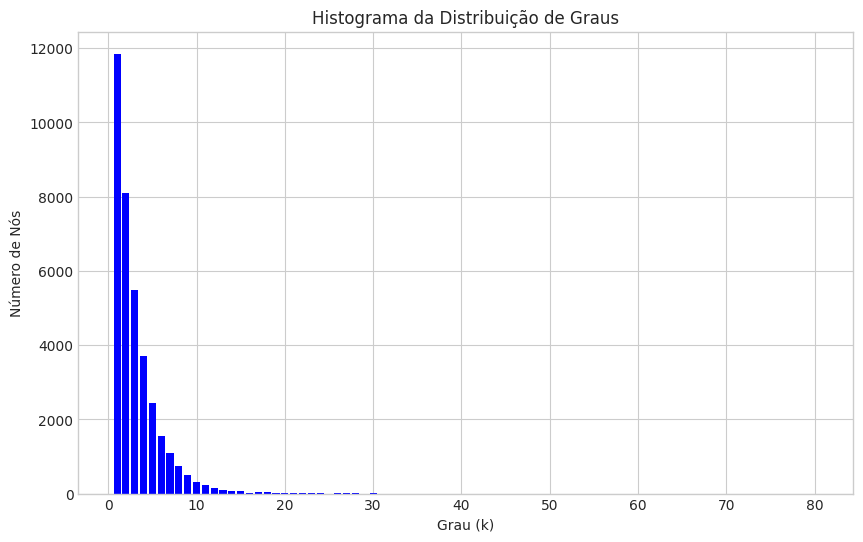

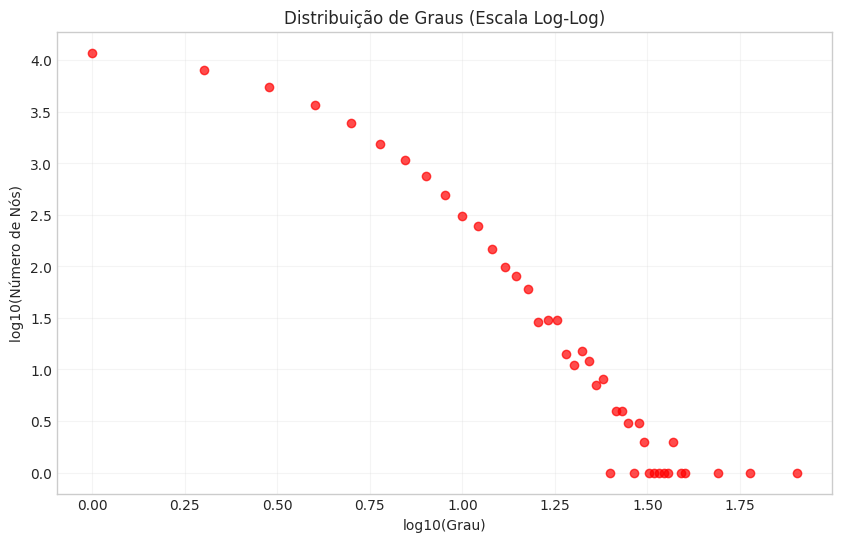

In [15]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_counts = collections.Counter(degree_sequence)  
deg, cnt = zip(*degree_counts.items())

# Filtrar contagens zero para o gráfico log-log (logaritmo de zero é indefinido)  
positive_cnt_indices = np.array(cnt) > 0  
logx = np.log10(np.array(deg)[positive_cnt_indices])  
logy = np.log10(np.array(cnt)[positive_cnt_indices])

# Histogram Plot  
plt.figure(figsize=(10, 6))  
plt.bar(deg, cnt, width=0.8, color='b')  
plt.title("Histograma da Distribuição de Graus")  
plt.xlabel("Grau (k)")  
plt.ylabel("Número de Nós")  
plt.show()

# Log-Log Plot  
plt.figure(figsize=(10, 6))  
plt.plot(logx, logy, 'o', color='r', alpha=0.7)  
plt.title("Distribuição de Graus (Escala Log-Log)")  
plt.xlabel("log10(Grau)")  
plt.ylabel("log10(Número de Nós)")  
plt.grid(True, which="both", ls="-", alpha=0.2)  
plt.show()

### E. Média das Distâncias entre Pares (Average Shortest Path Length)

A média das distâncias entre pares (ASPL), denotada como ⟨L⟩, é definida como o número médio de passos (arestas) ao longo dos caminhos mais curtos para todos os pares possíveis de nós na rede. Serve como uma medida crucial da eficiência da rede no transporte de informações ou massa. Um ASPL menor geralmente indica uma rede mais eficiente, interconectada e facilmente navegável, onde a informação pode viajar rapidamente entre quaisquer dois pontos.

In [16]:
import random

def estimated_average_path_length(graph, num_samples):
    total_distances = 0
    num_paths = 0
    nodes = list(graph.nodes())
    sampled_nodes = random.sample(nodes, min(num_samples, len(nodes)))

    for source_node in sampled_nodes:
        # Calcula o caminho mais curto de 'source_node' para todos os outros nós
        lengths = nx.single_source_shortest_path_length(graph, source_node)
        for target_node, length in lengths.items():
            if source_node != target_node: # Não conte distância de nó para ele mesmo
                total_distances += length
                num_paths += 1
    return total_distances / num_paths if num_paths > 0 else 0


# --- Se for calcular o valor exato (provavelmente inviável para seu grafo) ---
#avg_path_length_exact = nx.average_shortest_path_length(G)
#print(f"Média das Distâncias entre Pares (Exato): {avg_path_length_exact}")

In [17]:
num_nodes_to_sample = 100 # Ajuste este valor para controlar a precisão/velocidade

if nx.is_connected(G):        
    print("A rede é conectada.")
    avg_path_length_estimate = estimated_average_path_length(G, num_nodes_to_sample)   
    print(f"Média das Distâncias entre Pares: {avg_path_length_estimate:.2f} passos")  
else:  
    print("A rede é desconectada.") 
    avg_path_length_estimate = estimated_average_path_length(G, num_nodes_to_sample)    
    print(f"Média das Distâncias entre Pares: {avg_path_length_estimate:.2f} passos")


A rede é desconectada.
Média das Distâncias entre Pares: 9.97 passos


### F. Diâmetro da Rede (Diameter)

O diâmetro de uma rede é definido como o caminho mais curto mais longo entre quaisquer dois nós na rede. Ele representa a separação máxima ou a "distância" que a informação ou influência deve percorrer dentro da rede. É uma métrica crítica para entender a compactação geral da rede, sua eficiência e potenciais gargalos. Um diâmetro menor geralmente indica uma rede mais interconectada e eficiente.

In [18]:
import random

def estimated_diameter(graph, num_samples):
    max_overall_distance = 0
    nodes = list(graph.nodes())
    # Garante que não se amostre mais nós do que existem
    sampled_nodes = random.sample(nodes, min(num_samples, len(nodes)))

    for source_node in sampled_nodes:
        # Calcula o caminho mais curto de 'source_node' para todos os outros nós
        # nx.single_source_shortest_path_length retorna um dicionário {destino: distancia}
        lengths = nx.single_source_shortest_path_length(graph, source_node)

        # Encontra a maior distância a partir deste nó de origem
        # Exclui a distância 0 de um nó para ele mesmo
        if lengths:
            max_current_distance = max(length for length in lengths.values() if length > 0)
            if max_current_distance > max_overall_distance:
                max_overall_distance = max_current_distance
    return max_overall_distance



In [19]:
num_nodes_to_sample = 100 # Ajuste este valor para controlar a precisão/velocidade

if nx.is_connected(G):        
    print("A rede é conectada.")
    diam_estimate = estimated_diameter(G, num_nodes_to_sample)
    print(f"Estimativa do Diâmetro da Rede: {diam_estimate:.2f}")        
else:  
    print("A rede é desconectada.") 
    diam_estimate = estimated_diameter(G, num_nodes_to_sample)
    print(f"Estimativa do Diâmetro da Rede: {diam_estimate:.2f}")

A rede é desconectada.
Estimativa do Diâmetro da Rede: 27.00


In [31]:
lcc_nodes = list(max(nx.connected_components(G), key=len)) 

# 3. Criar o subgrafo a partir da lista de nós
LCC_subgraph = G.subgraph(lcc_nodes).copy() # Usar .copy() para ter um grafo independente
print(f"Número de nós no grafo original (G): {G.number_of_nodes()}")
print(f"Número de nós no Maior Componente Conectado (LCC): {LCC_subgraph.number_of_nodes()}")
print("-" * 30)

### PASSO 2: Amostrar 20% dos Nós do LCC
# Pega a lista de todos os nós que estão no LCC
lcc_node_list = list(LCC_subgraph.nodes())
# Calcula quantos nós correspondem a 20% do LCC
# Usamos int() para garantir que o resultado seja um número inteiro
num_nodes_to_sample = int(LCC_subgraph.number_of_nodes() * 0.01)
# Seleciona aleatoriamente 'num_nodes_to_sample' nós da lista, sem reposição
sampled_nodes = random.sample(lcc_node_list, k=num_nodes_to_sample)
print(f"Vamos amostrar 20% do LCC, o que corresponde a {num_nodes_to_sample} nós.")
# print(f"Nós amostrados: {sampled_nodes}") # Descomente para ver os nós
print("-" * 30)

### PASSO 3: Criar o Subgrafo Final com os 20% dos Nós
# Cria o subgrafo final a partir do LCC, usando apenas os nós amostrados
# Este novo grafo conterá os nós amostrados e TODAS as arestas que existiam ENTRE ELES no LCC
LCC_20_percent = LCC_subgraph.subgraph(sampled_nodes).copy()
print(f"Novo subgrafo criado com {LCC_20_percent.number_of_nodes()} nós e {LCC_20_percent.number_of_edges()} arestas.")
lcc_ = nx.subgraph(G, lcc_nodes)

Número de nós no grafo original (G): 36595
Número de nós no Maior Componente Conectado (LCC): 30420
------------------------------
Vamos amostrar 20% do LCC, o que corresponde a 304 nós.
------------------------------
Novo subgrafo criado com 304 nós e 4 arestas.


### G. Centradilidade Autovetor.

Mede a influência de um vertice na rede. atravez de dois fatores:

* Seu grau 
* Importância dos seus vizinhos.

In [32]:
eigenvector_centrality = nx.eigenvector_centrality(lcc_)

### Centradilidade Katz.

Tem o mesmo principio do autovetor, porem, a diferença é que, inicialmente, defini-se uma pequena quantidade de centralidade para cada vértice da rede.

erro: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

Aprendido: A centralidade de Katz não é calculada com uma fórmula simples e direta. Em vez disso, ela é encontrada usando um processo iterativo chamado Iteração de Potência (Power Iteration). O algoritmo começa com uma estimativa inicial para os scores de centralidade e refina essa estimativa repetidamente a cada passo (ou "iteração"). Ele para quando os scores mudam muito pouco entre uma iteração e a seguinte (o que significa que eles "convergiram" para uma solução).

In [38]:
# 1. Obtenha a matriz de adjacência em um formato que o SciPy possa usar
# Use to_scipy_sparse_array para versões mais novas do NetworkX
A = nx.to_scipy_sparse_array(lcc_, nodelist=lcc_.nodes())
# 2. Calcule o maior autovalor (raio espectral)
# k=1 significa que queremos o maior. 'LM' significa 'Largest Magnitude' (maior magnitude).
# O resultado é um array, então pegamos o primeiro elemento.
# Usamos a parte real para evitar pequenos componentes imaginários de problemas de precisão numérica.
raio_espectral = np.real(linalg.eigs(A, k=1, which='LM')[0][0])
# 3. Defina o alpha para ser um pouco menor que seu máximo teórico
alpha = (1 / raio_espectral) * 0.99  # Usando 99% do valor máximo por segurança
print(f"Raio Espectral Calculado: {raio_espectral:.4f}")
print(f"Alpha seguro para usar: {alpha:.4f}")
# 4. Rode novamente a centralidade de Katz com o alpha calculado
katz_centrality = nx.katz_centrality(lcc_, alpha=alpha, max_iter=1000) # Também pode aumentar o max_iter aqui


Raio Espectral Calculado: 14.6447
Alpha seguro para usar: 0.0676


### Centradilidade PageRank.

In [39]:
pagerank_centrality = nx.pagerank(lcc_)

### Centradilidade Betwenness.

In [41]:
betweenness_centrality = nx.betweenness_centrality(lcc_, k=100)

In [42]:
# 3. Organização dos Dados e Cálculo da Média
# Criando um DataFrame do pandas para melhor visualização e manipulação
df_centrality = pd.DataFrame({
    'Autovetor': pd.Series(eigenvector_centrality),
    'Katz': pd.Series(katz_centrality),
    'PageRank': pd.Series(pagerank_centrality),
    'Betweenness': pd.Series(betweenness_centrality)
})

# Calculando a média das quatro medidas de centralidade para cada nodo
df_centrality['Média'] = df_centrality.mean(axis=1)

# Ordenando os resultados pela média para facilitar a interpretação
df_centrality_sorted = df_centrality.sort_values(by='Média', ascending=False)


# 4. Apresentação dos Resultados
print("Tabela de Centralidades dos Nodos:")
print(df_centrality_sorted.round(4)) # Arredondando para 4 casas decimais

Tabela de Centralidades dos Nodos:
       Autovetor    Katz  PageRank  Betweenness   Média
1181      0.3094  0.2971    0.0002       0.0386  0.1613
1179      0.2822  0.2710    0.0002       0.0164  0.1424
2602      0.2535  0.2426    0.0001       0.0062  0.1256
3314      0.2502  0.2390    0.0001       0.0018  0.1228
1174      0.2440  0.2332    0.0001       0.0033  0.1201
...          ...     ...       ...          ...     ...
30292     0.0000  0.0010    0.0000       0.0000  0.0003
31489     0.0000  0.0010    0.0000       0.0000  0.0003
28482     0.0000  0.0010    0.0000       0.0000  0.0003
19974     0.0000  0.0010    0.0000       0.0000  0.0003
26820     0.0000  0.0010    0.0000       0.0000  0.0003

[30420 rows x 5 columns]


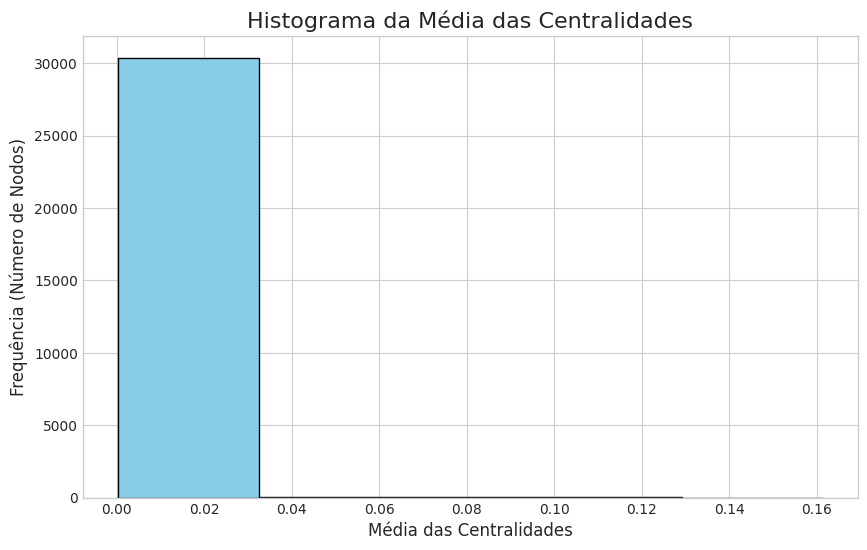

In [43]:
# 5. Plot do Histograma
# Configurando o estilo do plot
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(10, 6))
plt.hist(df_centrality['Média'], bins=5, color='skyblue', edgecolor='black')

# Adicionando títulos e legendas
plt.title('Histograma da Média das Centralidades', fontsize=16)
plt.xlabel('Média das Centralidades', fontsize=12)
plt.ylabel('Frequência (Número de Nodos)', fontsize=12)

# Exibindo o gráfico
plt.show()

# Opcional: Visualização do grafo
# plt.figure(figsize=(8, 8))
# pos = nx.spring_layout(G, seed=42) # Posição dos nodos para visualização consistente
# nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=16, font_weight='bold')
# plt.title("Visualização do Grafo Fictício")
# plt.show()

### Desenhar o subgrafo com os 1000 nodos com maior PageRank. 

A cor do nodo deve representar o seu valor de PageRank. Usar a rede do item (g).


Calculando o PageRank para todos os nodos...
Cálculo do PageRank concluído.
Top 1000 nodos com maior PageRank identificados.
Subgrafo criado com 1000 nodos e 1201 arestas.
Preparando a visualização do subgrafo...
Plot gerado. Exibindo a imagem...


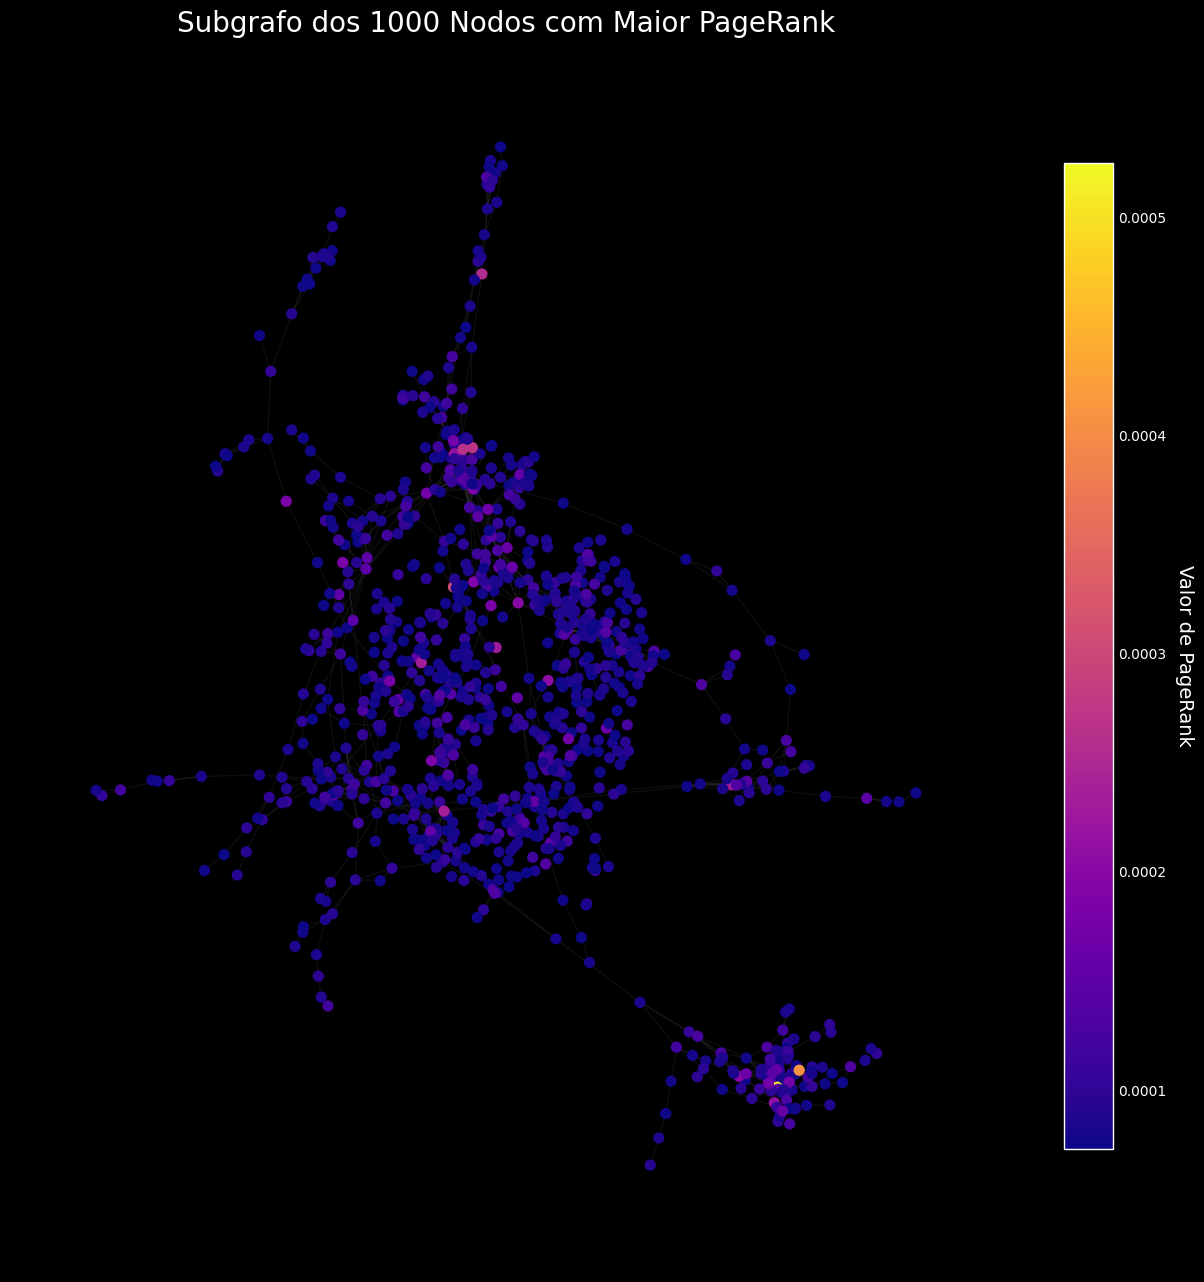

In [44]:
# --- 2. Cálculo do PageRank ---
print("Calculando o PageRank para todos os nodos...")
# A função pagerank retorna um dicionário {nodo: valor_pagerank}
pagerank = nx.pagerank(lcc_)
print("Cálculo do PageRank concluído.")

# --- 3. Identificação dos 1000 Nodos com Maior PageRank ---
# Convertendo o dicionário para uma Series do pandas para facilitar a ordenação
pagerank_series = pd.Series(pagerank)

# Ordenando os nodos pelo valor de PageRank em ordem decrescente e pegando os 1000 primeiros
top_1000_nodes = pagerank_series.nlargest(1000).index.tolist()
print("Top 1000 nodos com maior PageRank identificados.")

# --- 4. Criação do Subgrafo ---
# Criando o subgrafo que contém apenas os nodos da lista top_1000_nodes
S = G.subgraph(top_1000_nodes)
print(f"Subgrafo criado com {S.number_of_nodes()} nodos e {S.number_of_edges()} arestas.")

# --- 5. Visualização do Subgrafo ---
print("Preparando a visualização do subgrafo...")
plt.style.use('dark_background') # Usando um fundo escuro para destacar as cores
fig, ax = plt.subplots(figsize=(16, 16))

# Posição dos nodos para a visualização (pode demorar um pouco para 1000 nodos)
# O layout 'spring' trata os nodos como massas e as arestas como molas
pos = nx.spring_layout(S, seed=42, iterations=50)

# Pegando os valores de PageRank apenas para os nodos do subgrafo
node_colors = [pagerank[node] for node in S.nodes()]

# Desenhando o grafo
nodes = nx.draw_networkx_nodes(
    S,
    pos,
    node_size=50,
    node_color=node_colors,
    cmap=plt.cm.plasma # Usando um mapa de cores vibrante (plasma)
)
edges = nx.draw_networkx_edges(S, pos, alpha=0.1, edge_color='gray')

# Adicionando uma barra de cores para mapear cores a valores de PageRank
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Valor de PageRank', rotation=270, labelpad=20, fontsize=14)

# Configurações finais do plot
ax.set_title('Subgrafo dos 1000 Nodos com Maior PageRank', fontsize=20)
plt.axis('off') # Remove os eixos
print("Plot gerado. Exibindo a imagem...")
plt.show()